In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import copy

from astropy.io import fits
from astropy.cosmology import FlatLambdaCDM
from astropy.visualization import make_lupton_rgb

import lenstronomy.Util.param_util as param
import lenstronomy.Util.util as util
from lenstronomy.SimulationAPI.sim_api import SimAPI

In [2]:
DES_camera = {'read_noise': 7.,  # std of noise generated by read-out (in units of electrons)
               'pixel_scale': 0.2637,  # scale (in arcseconds) of pixels
               'ccd_gain': 4.  # electrons/ADU (analog-to-digital unit). A gain of 8 means that the camera digitizes the CCD signal so that each ADU corresponds to 8 photoelectrons.
              }

DES_g_band_obs = {'exposure_time': 90.,  # exposure time per image (in seconds)
                   'sky_brightness': 35.01,  # sky brightness (in magnitude per square arcseconds)
                   'magnitude_zero_point': 30,  # magnitude in which 1 count per second per arcsecond square is registered (in ADU's)
                   'num_exposures': 7,  # number of exposures that are combined
                   'seeing': 1.12,  # full width at half maximum of the PSF (if not specific psf_model is specified)
                   'psf_type': 'GAUSSIAN',  # string, type of PSF ('GAUSSIAN' and 'PIXEL' supported)
                   'kernel_point_source': None  # 2d numpy array, model of PSF centered with odd number of pixels per axis (optional when psf_type='PIXEL' is chosen)
                  }

DES_r_band_obs = {'exposure_time': 90.,  
                   'sky_brightness': 34.7,  
                   'magnitude_zero_point': 30,  
                   'num_exposures': 7,  
                   'seeing': 1.12,  
                   'psf_type': 'GAUSSIAN', 
                  }

DES_i_band_obs = {'exposure_time': 90.,  
                   'sky_brightness': 35.1,  
                   'magnitude_zero_point': 30,  
                   'num_exposures': 7,  
                   'seeing': 1.12,  
                   'psf_type': 'GAUSSIAN', 
                  }

numpix = 46 # 

kwargs_g_band = util.merge_dicts(DES_camera, DES_g_band_obs)
kwargs_r_band = util.merge_dicts(DES_camera, DES_r_band_obs)
kwargs_i_band = util.merge_dicts(DES_camera, DES_i_band_obs)

kwargs_numerics = {'point_source_supersampling_factor': 1}

cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.)

In [3]:
# Function to pick the centers for source1 & source2
def pick_centers(kwargs_lens):
    radius = kwargs_lens['theta_E']
    c1, c2 = random.uniform(0, 1)*radius, random.uniform(0, 1)*radius
    d = np.sqrt(c1**2 + c2**2)
    while(d > radius):
        c1, c2 = random.uniform(0, 1)*radius, random.uniform(0, 1)*radius
        d = np.sqrt(c1**2 + c2**2)
    return c1, c2

In [4]:
# Color distribution
colors = pd.read_csv('color_distribution/source_colors.csv')
colors = colors[colors['DNF_ZMEAN_MOF'] > 0.01] #When there is no data z<0
colors = colors[colors['MAG_PSF_G'] < 30.] [colors['MAG_PSF_R'] < 30.] [colors['MAG_PSF_I'] < 30.] #decent magnitude
colors['g_r'] = colors['MAG_PSF_G'] - colors['MAG_PSF_R'] # g-r color
colors['r_i'] = colors['MAG_PSF_R'] - colors['MAG_PSF_I'] # r-i color

dz = 0.1 # Range of redshift for filtering
dm = 0.2 # Range of magnitude for filtering

def color_distribution(z, m):
    #objects with a redshift between z - dz and z + dz, same idea for apparent magnitude
    fcolors = colors[(colors['DNF_ZMEAN_MOF'] > z - dz)] [(colors['DNF_ZMEAN_MOF'] < z + dz)] 
    fcolors = fcolors[(colors['MAG_PSF_G'] > m - dm)] [(colors['MAG_PSF_G'] < m + dm)]
    random_object = fcolors.sample()
    g_r = random_object['g_r'].values[0]
    r_i = random_object['r_i'].values[0]
    return(g_r, r_i)

/Users/jimenagonzalez/Software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


In [5]:
def simulation(redshifts, sigma , centers, lens_ellip, i):
   
    kwargs_model_physical = {'lens_model_list': ['SIE'],  # list of lens models to be used
                          'lens_redshift_list': [redshifts['lens']],  # list of redshift of the deflections
                          # list of unlensed light models to be used
                          #'lens_light_model_list': ['SERSIC_ELLIPSE'],  
                          # list of extended source models to be used
                          'source_light_model_list': ['SERSIC_ELLIPSE', 'SERSIC'],  
                          # list of redshfits of the sources in same order as source_light_model_list
                          'source_redshift_list': [redshifts['source1'], redshifts['source2']],  
                          'cosmo': cosmo,  # astropy.cosmology instance
                          # redshift of the default source (if not further specified by 'source_redshift_list')
                          'z_source': z_source2}  
                           #and also serves as the redshift of lensed point sources}

    sim_g = SimAPI(numpix=numpix, kwargs_single_band=kwargs_g_band, kwargs_model=kwargs_model_physical)
    sim_r = SimAPI(numpix=numpix, kwargs_single_band=kwargs_r_band, kwargs_model=kwargs_model_physical)
    sim_i = SimAPI(numpix=numpix, kwargs_single_band=kwargs_i_band, kwargs_model=kwargs_model_physical)
    
    imSim_g = sim_g.image_model_class(kwargs_numerics)
    imSim_r = sim_r.image_model_class(kwargs_numerics)
    imSim_i = sim_i.image_model_class(kwargs_numerics)

    #lens mass model
    kwargs_mass = [{'sigma_v': sigma, 'center_x': 0, 'center_y': 0, 
                    'e1': lens_ellip[0], 'e2': lens_ellip[1]}]
    kwargs_lens = sim_g.physical2lensing_conversion(kwargs_mass=kwargs_mass)
    #print(kwargs_lens[0]['theta_E'])
    #cut on the Einstein radius of the lens
    #if(kwargs_lens[0]['theta_E'] < 0.8):
    #    return None
    
    #colors of the other bands for each source
    g_r_source_1, r_i_source_1 = color_distribution(z_source1, 22)
    g_r_source_2, r_i_source_2 = color_distribution(z_source2, 23)
    
    #Sources light distributions
    m1, r1, n1 = random.uniform(20, random.uniform(20.1, 22)), random.uniform(0.2, 0.4), random.uniform(1.2, 1.7)
    m2, r2, n2 = random.uniform(m1, 24), random.uniform(0.2, 0.4), random.uniform(1.2, 1.7)
    #pick centers of source 1 & 2 inside the Einstein Radius
    c1x, c1y = pick_centers(kwargs_lens[0])
    c2x, c2y = pick_centers(kwargs_lens[0])
    #sources light:
    kwargs_source_mag_g_1 = [{'magnitude': m1, 'R_sersic': r1, 'n_sersic': n1, 'e1': 0., 'e2': 0.,
                              'center_x': c1x, 'center_y': c1y}]
    kwargs_source_mag_g_2 = [{'magnitude': m2, 'R_sersic': r2, 'n_sersic': n2, 
                              'center_x': c2x, 'center_y': c2y}]
    
    kwargs_source_mag_r_1 = copy.deepcopy(kwargs_source_mag_g_1)
    kwargs_source_mag_r_1[0]['magnitude'] -= g_r_source_1
    
    kwargs_source_mag_r_2 = copy.deepcopy(kwargs_source_mag_g_2)
    kwargs_source_mag_r_2[0]['magnitude'] -= g_r_source_2
    
    kwargs_source_mag_i_1 = copy.deepcopy(kwargs_source_mag_r_1)
    kwargs_source_mag_i_1[0]['magnitude'] -= r_i_source_1
    
    kwargs_source_mag_i_2 = copy.deepcopy(kwargs_source_mag_r_2)
    kwargs_source_mag_i_2[0]['magnitude'] -= r_i_source_2
    
    kwargs_source_mag_g = kwargs_source_mag_g_1 + kwargs_source_mag_g_2
    kwargs_source_mag_r = kwargs_source_mag_r_1 + kwargs_source_mag_r_2
    kwargs_source_mag_i = kwargs_source_mag_i_1 + kwargs_source_mag_i_2
    
    kwargs_lens_light_g, kwargs_source_g , point = sim_g.magnitude2amplitude(kwargs_lens_light_mag=None, 
                                                    kwargs_source_mag=kwargs_source_mag_g, kwargs_ps_mag=None)
    kwargs_lens_light_r, kwargs_source_r , point = sim_r.magnitude2amplitude(kwargs_lens_light_mag=None, 
                                                    kwargs_source_mag=kwargs_source_mag_r, kwargs_ps_mag=None)
    kwargs_lens_light_i, kwargs_source_i , point = sim_i.magnitude2amplitude(kwargs_lens_light_mag=None, 
                                                    kwargs_source_mag=kwargs_source_mag_i, kwargs_ps_mag=None)
    
    image_g = imSim_g.image(kwargs_lens, kwargs_source_g)
    image_r = imSim_r.image(kwargs_lens, kwargs_source_r)
    image_i = imSim_i.image(kwargs_lens, kwargs_source_i)
    
    image_g += sim_g.noise_for_model(model=image_g)
    image_r += sim_r.noise_for_model(model=image_r)
    image_i += sim_i.noise_for_model(model=image_i)
    
    #Writing the fit files for each band, I already saved all the files
    """   
    hdu = fits.PrimaryHDU(image_g)
    hdul = fits.HDUList([hdu])
    hdul.writeto('Data/Sim/sim_' + str(i) + '_g.fits')
    
    hdu = fits.PrimaryHDU(image_r)
    hdul = fits.HDUList([hdu])
    hdul.writeto('Data/Sim/sim_' + str(i) + '_r.fits')
    
    hdu = fits.PrimaryHDU(image_i)
    hdul = fits.HDUList([hdu])
    hdul.writeto('Data/Sim/sim_' + str(i) + '_i.fits')
    """    
    
    rgb = make_lupton_rgb(np.log10(image_g), np.log10(image_r), np.log10(image_i), Q=2., stretch=4.)
    
    plt.figure()
    plt.imshow(rgb)
    plt.xticks([], [])
    plt.yticks([], [])
    #plt.savefig('Image' + str(i) + '.png', bbox_inches='tight')
    #plt.show(block=True)
    plt.close()
    return(kwargs_lens[0]['theta_E'])

In [6]:
#data
data = pd.read_csv('Data/redmagic_sdss_allcolumns.csv')
data = pd.read_csv('Data/all_data_sim.csv')
data.head()
print(len(data))

19727


In [7]:
Einstein_radii = []
for index, row in data.iterrows():
    #if index == 10000:
    #    break
    DES_g_band_obs['seeing'] = row['FWHM_WMEAN_G'] 
    DES_r_band_obs['seeing'] = row['FWHM_WMEAN_R']
    DES_i_band_obs['seeing'] = row['FWHM_WMEAN_I']
        
    coadd_id = int(row['COADD_OBJECT_ID'])
    z_lens = row['Z']
    z_source1 = random.uniform(z_lens, z_lens + 0.35) #1.2
    z_source2 = random.uniform(z_source1, z_source1 + 0.35) #1.3
    redshifts = {'lens': z_lens, 'source1': z_source1, 'source2': z_source2}
    dispersion = row['VEL_DISP']
    center_lens = [0, 0]
    center_source1 = [random.uniform(-1, 1), random.uniform(-1, 1)]
    center_source2 = [random.uniform(-1, 1), random.uniform(-1, 1)]
    centers = {'lens': center_lens, 'source1': center_source1, 'source2': center_source2}
    
    angle, ratio = param.ellipticity2phi_q(row['SOF_CM_G_1'], row['SOF_CM_G_2'])
    angle += 0.698132*random.uniform(-1, 1) #noise between -40 and 40 degrees
    ratio = random.uniform(0.001, 1) #distribution for the axis ratio
    e1, e2 = param.phi_q2_ellipticity(angle, ratio)
    lens_ellip = [e1, e2]
    
    theta = simulation(redshifts, dispersion, centers, lens_ellip, coadd_id)
    if(theta != None): Einstein_radii.append(theta)

/Users/jimenagonzalez/Software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/Users/jimenagonzalez/Software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jimenagonzalez/Software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:95: RuntimeWarning: invalid value encountered in log10


In [8]:
#! convert -delay 50 -loop 0 *.png Only_sources_data.gif
#! rm *.png
# with 0.9 cut 10728 total

19727


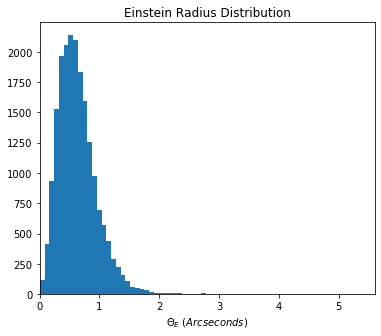

In [11]:
print(len(Einstein_radii))

plt.figure(figsize=(6,5))
plt.hist(Einstein_radii, 80)
plt.title('Einstein Radius Distribution')
plt.xlabel(r'$\Theta_E\ (Arc seconds)$')
plt.xlim(0,5.6)
plt.show()

In [21]:
new_data = pd.DataFrame(Einstein_radii)
print(len(new_data[new_data[0] > 0.4]))

14778
